In [63]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
#from sklearn.externals.joblib import Parallel, delayed, effective_n_jobs
from sklearn.isotonic import IsotonicRegression

def NMDSfunc(dissimilarities, n_dimensions=2, max_iter=300, verbose=False, eps=1e-3, random_state=None):
    '''
    dissimilarities: matrix
    eps: used for convergence
    '''
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)
    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    #Random initial configuration
    X = random_state.rand(n_samples * n_dimensions)
    X = X.reshape((n_samples, n_dimensions))

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)
        dis_flat = dis.ravel()
        dis_flat_w = dis_flat[sim_flat != 0]

        # Find disparities using monotonic regression
        disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
        disparities = dis_flat.copy()
        disparities[sim_flat != 0] = disparities_flat
        disparities = disparities.reshape((n_samples, n_samples))
        disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) / (disparities ** 2).sum())
        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose:
            print('iteration: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('convergence: breaking at iteration %d with stress %s' % (it,stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def NMDS(dissimilarities, n_dimensions=2, n_init=4,
            max_iter=300, verbose=False, eps=1e-3, random_state=None):
    """
    Multiple(n_init) iterations to find the best stress at a particular dimension
    """
    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    best_pos, best_stress = None, None
    for it in range(n_init):
        pos, stress, n_iter_ = NMDSfunc(dissimilarities, n_dimensions=n_dimensions, max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state)
        #print(pos)
        print(stress)
        if best_stress is None or stress < best_stress:
            best_stress = stress
            best_pos = pos.copy()
            best_iter = n_iter_
            
    return best_pos, best_stress, best_iter


class MDS():
    def __init__(self, n_dimensions=2,  n_init=4,
                 max_iter=300, verbose=False, eps=1e-3,
                 random_state=None):
        self.n_dimensions = n_dimensions
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, X, y=None):
      
        #self.fit_transform(X)
        X = check_array(X)
        self.dissimilarity_matrix_ = X
        
        self.embedding, self.stress, self.n_iter = NMDS(self.dissimilarity_matrix_,
            n_dimensions=self.n_dimensions, n_init=self.n_init,
            max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state)
        
        return self

In [64]:
sim = np.array([[0, 5, 3, 4],
                [5, 0, 2, 2],
                [3, 2, 0, 1],
                [4, 2, 1, 0]])
mds_clf = MDS()
a = mds_clf.fit(sim)

0.00455517706873
0.00568620527718
0.00360615225171
0.00216097996829


In [65]:
a.stress

0.0021609799682891944

In [66]:
a.embedding

array([[-0.51171021, -0.12542663],
       [ 0.50459287,  0.09042339],
       [ 0.04074435, -0.29824396],
       [-0.04095825,  0.3481076 ]])

In [67]:
sim2 = np.array([[0, 1, 4, 5, 3, 4, 2, 8, 8, 5, 7, 1],
                [1, 0, 3, 8, 2, 6, 2, 7, 8, 8, 7, 2],
                [4, 3, 0, 7, 2, 3, 3, 7, 8, 6, 4, 3],
                [5, 8, 7, 0, 8, 9, 3, 8, 2, 2, 9, 5],
                [3, 2, 2, 8, 0, 6, 4, 8, 9, 6, 4, 2],
                [4, 6, 3, 9, 6, 0, 1, 3, 9, 8, 5, 3],
                [2, 2, 3, 3, 4, 1, 0, 4, 3, 6, 7, 1],
                [8, 7, 7, 8, 8, 3, 4, 0, 9, 6, 9, 5],
                [8, 8, 8, 2, 9, 9, 3, 9, 0, 4, 9, 9],
                [5, 8, 6, 2, 6, 8, 6, 6, 4, 0, 4, 3],
                [7, 7, 4, 9, 4, 5, 7, 9, 9, 4, 0, 6],
                [1, 2, 3, 5, 2, 3, 1, 5, 9, 3, 6, 0]])
mds_2 = MDS(n_dimensions=4)
b = mds_2.fit(sim2)


0.763746574026
0.94772071077
0.52778551819
0.612545026295


In [68]:
b.stress

0.52778551818987518

In [69]:
output = []
for i in range(1,15):
    model = MDS(n_dimensions=i)
    b = model.fit(sim2)
    output.append(b)


5.00819593764
5.52146148815
4.66860175973
4.05828817639
2.37781219487
2.12287849908
2.32413494542
3.14245920246
0.827824971442
0.887896083388
1.44874899525
1.37563201384
0.648641795892
0.868577490965
0.33417083569
0.937689612324
0.434484652225
0.310639960646
0.607136444039
0.594548555239
0.384825930397
0.632477534911
0.409056291966
0.281648969797
0.406314332752
0.27979877505
0.134718314875
0.315800252407
0.134931210885
0.231837198166
0.244590567412
0.272076108706
0.19600683592
0.189796325615
0.187995777286
0.117379841531
0.199954489019
0.147362356211
0.134880828786
0.15248717618
0.134828689347
0.128596621855
0.139388384365
0.13577860186
0.129695375957
0.11246954555
0.149057286608
0.104720124687
0.170505341848
0.146778627885
0.117009980621
0.158717010155
0.114406309315
0.1113715348
0.0885778377139
0.0923920837029


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


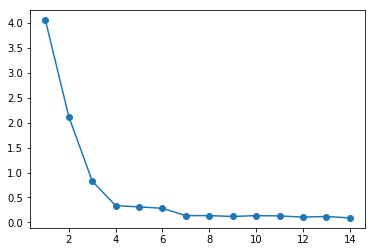

In [70]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()

def test():
    
    pass


In [124]:
import pandas as pd
a = pd.read_csv('SimilarityMatrixv2.csv')
dsim = (7- a.drop(a.columns[0], axis = 1)).values

#nmds = MDS(n_dimensions=40)
#ans = mds_2.fit(dsim)

output = []
for i in range(1,15):
    nmds = MDS(n_dimensions=i)
    ans = nmds.fit(dsim)
    output.append(ans)

80.1444904789
79.9718736113
77.0793553028
77.2062633157
42.1739977165
40.8131219242
41.0667280816
42.1913332682
25.6407344158
26.1341016462
28.3532176822
26.976100267
18.4951247606
19.6337942293
18.0559639713
17.8953081663
13.5997853127
13.4395389826
13.2735728165
13.729886039
11.0009731965
10.3236553709
10.3529967715
10.2715616157
9.24835878915
9.13742759243
8.68759608515
8.8638632957
7.21994624072
7.24478215787
6.99187242257
7.37526213836
6.62348013756
6.36330693193
6.27230024225
7.02206484261
5.6208688102
5.84530146856
5.52048493546
5.65523281429
4.41705401527
5.23426051245
4.822818609
4.96595644081
4.67450345807
4.45846939082
4.62350580505
4.27699038581
4.10790056423
4.05996648359
4.00528521695
4.37530185921
3.62281210653
3.79091160857
3.79521328853
3.37786146041


In [19]:
#ans.stress

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


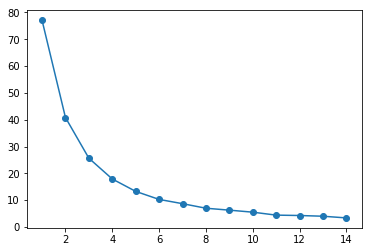

In [125]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()

In [112]:
dsim

array([[ 0.        ,  4.        ,  4.33333333, ...,  4.33333333,
         4.33333333,  5.        ],
       [ 4.        ,  0.        ,  3.75      , ...,  3.75      ,
         1.        ,  4.5       ],
       [ 4.33333333,  3.75      ,  0.        , ...,  2.        ,
         0.        ,  6.        ],
       ..., 
       [ 4.33333333,  3.75      ,  2.        , ...,  0.        ,
         1.        ,  4.66666667],
       [ 4.33333333,  1.        ,  0.        , ...,  1.        ,
         0.        ,  4.        ],
       [ 5.        ,  4.5       ,  6.        , ...,  4.66666667,
         4.        ,  0.        ]])

In [126]:
nmds2 = MDS(n_dimensions=2)
ans2 = nmds2.fit(dsim)

'''
from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)
'''


40.4804204402
40.4530197879
42.8767740258
41.5860589138


'\nfrom sklearn.decomposition import PCA\nclf = PCA(n_components=2)\nnpos = clf.fit_transform(ans2.embedding)\n'

In [127]:
npos = ans2.embedding
npos

array([[ 0.06884978,  0.42525236],
       [ 0.26590355, -0.29954647],
       [ 0.4162211 ,  0.11205533],
       [ 0.03992199,  0.24085053],
       [-0.42671025, -0.04181574],
       [ 0.31638194,  0.15674249],
       [ 0.37640696,  0.22028619],
       [ 0.42772992, -0.05164282],
       [ 0.11231329, -0.00128544],
       [-0.09614278,  0.24422846],
       [-0.37641701,  0.36896132],
       [-0.24548325, -0.45200636],
       [ 0.39055523, -0.30773377],
       [ 0.19110625, -0.50154917],
       [ 0.19623228,  0.04152501],
       [-0.17829801,  0.35269058],
       [-0.16761255,  0.49031704],
       [ 0.19395929, -0.18531212],
       [ 0.20257686,  0.39862017],
       [ 0.4281761 , -0.21294226],
       [-0.31195583, -0.53736467],
       [ 0.05948166, -0.52575122],
       [ 0.27202681,  0.33734563],
       [-0.15069095, -0.04939735],
       [-0.4048918 ,  0.07349748],
       [-0.33847948, -0.38189358],
       [-0.13895394,  0.55626394],
       [-0.40417113,  0.19726431],
       [-0.45771752,

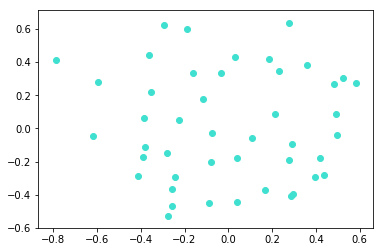

In [114]:
from matplotlib import pyplot as plt
plt.scatter(npos[:, 0], npos[:, 1], color='turquoise',  label='NMDS')
plt.show()

In [128]:
## labels for pairs
labels_pairs = ['ac', 'aa', 'ar', 'at', 'bh', 'buh', 'de', 'dro', 'dra', 
                'dc', 'et', 'fb', 'frc', 'fuc', 'gat', 'gd', 'ge' ,'gs',
                'grt', 'hd', 'hs', 'im', 'ms' , 'mc', 'mt', 'pa', 'pb',
                'ps', 'rs', 'rp', 'rv', 'rd', 'sk', 'se', 'ss', 'st', 'tl',
                'tt', 'te', 'tm', 'vr', 'wr', 'wd', 'wm', 'wl']
len(set(labels_pairs))

45

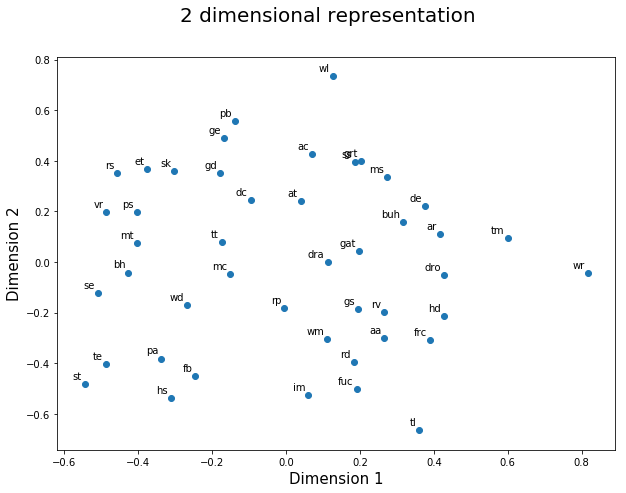

In [129]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show()  

84.3745641951
79.6108141137
82.6565680953
81.5845667487
44.0742822979
45.2387024032
43.0081778374
45.2023831329
28.314975847
27.6468476397
27.2315633034
27.9070172852
19.2373090688
19.4099859223
19.5649991458
19.5920262021
15.5588150685
14.502477371
14.90848057
14.8308494624
10.8988431903
11.3225791563
10.8791596079
11.4575452454
9.13570828422
9.16202366531
9.37567633795
9.80173522785
7.40022812087
8.04895948163
7.41988354776
8.30474944306
6.48492399076
7.1371876681
6.87146123072
6.83129553051
5.79364261524
5.83762590615
6.26177120676
6.07133689992
5.58687060001
5.06468475657
5.35126560616
5.45301070048
4.68729400946
4.57122443979
4.50750971787
4.38045383264
4.19628583442
4.43877083827
4.37914208299
4.14394679474
3.75986549681
3.72415198007
3.79371400306
4.08248431561


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


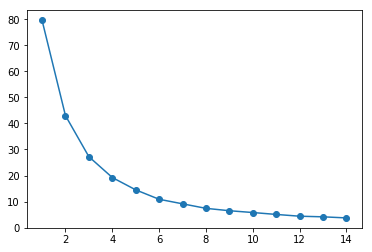

43.1392897814
43.1319349896
43.9531157094
44.0854990534


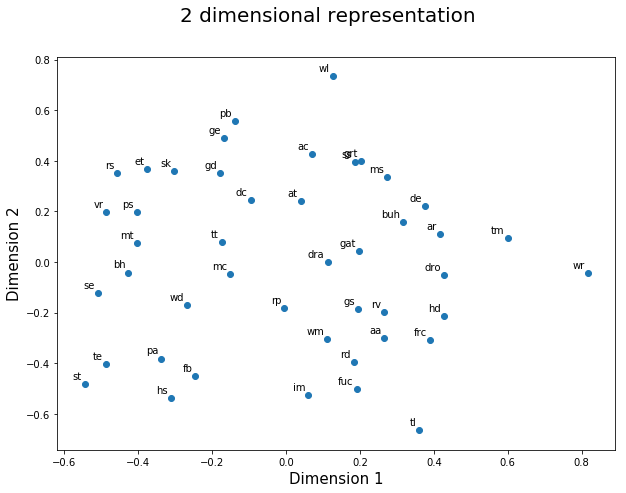

In [130]:
import pandas as pd
a = pd.read_csv('SimilarityMatrixStandardized.csv')
dsim = (7- a.drop(a.columns[0], axis = 1)).values

#nmds = MDS(n_dimensions=40)
#ans = mds_2.fit(dsim)

output = []
for i in range(1,15):
    nmds = MDS(n_dimensions=i)
    ans = nmds.fit(dsim)
    output.append(ans)
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()

nmds2 = MDS(n_dimensions=2)
ans2 = nmds2.fit(dsim)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show()  